# An unimodal predictor for TNBC immune-type from 3D medical image data
### Sub-title: The execution script to predict TNBC immune-types using 3D medical image data
#### Description: 유방암의 3D 진단영상 데이터를 분석하여 TNBC 환자의 면역형(IM:면역활성 vs. non-IM:면역비활성)을 예측하는 모델 구동 파이썬 스크립트 코드 입니다. 본 구동 스크립트와 함께 신규 입력 데이터의 예후를 예측할 기구축된 예측모델 (파일명: model.unimodal.MRI_TNBC_imtype.hdf5)이 동봉되어 있습니다.

### Step 1. Loading packages
>#### Description: 예측모델 구동에 필요한 패키지 전반을 로딩합니다. 아래 코드를 CTRL + Enter로 실행하십시오. 패키지가 설치되어 있지 않으면 conda install 또는 pip install 명령으로 설치하시기 바랍니다.

In [1]:
#import dependencies
import pandas as pd
import nibabel as nib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from matplotlib import pyplot

### Step 2. Loading meta data
>#### Description: TNBC 면역형을 예측할 입력데이터의 파일리스트를 로딩합니다. 파일 리스트 목록이 저장된 파일은 텍스트 형식입니다. 아래 코드에서 파일명 및 경로를 지정하십시오.
>#### 파일 리스트 목록의 컬럼양식은 다음과 같습니다:
>*[순서번호, 환자ID, nii파일이름, nii파일이_저장된_root경로]*
>#### 자세한 형식은 동봉된 예제 데이터의 양식("UC_003.nii_final.TNBC_unimodal.imtype.txt")을 참조하시기 바랍니다.
>#### 주의: 입력 3D medical image의 형식은 (80,80,30) shape의 NIFTI (.nii) 형식 입니다. 입력데이터가 다른 파일형식이라면 유틸리티가 동봉된 유스케이스(UC_EXTRA.UTILITIES) 폴더의 프로그램들을 참조하여 NIFTI 형식으로 변환 후 본 스크립트를 구동하시기 바랍니다.

In [2]:
# load meta data
meta_filename = "UC_003.nii_final.TNBC_unimodal.imtype.txt"

bcrDataFrame = pd.read_csv(meta_filename, sep="\t", index_col=0)

column_header_list = list(bcrDataFrame.columns)

patient_list = list(bcrDataFrame[column_header_list[0]])
nii_list = list(bcrDataFrame[column_header_list[1]])
data_root_folder = list(bcrDataFrame[column_header_list[2]])

print("#n of nii file of TNBC: " + str(len(nii_list)))

#n of nii file of TNBC: 77


### Step 3. Loading user input files of nifti-formatted images
>#### Description: 메타데이터 목록에서 지정되어 있는 사용자가 입력한 nifti 형식의 3D 이미지를 읽어 numpy array 형식으로 저장합니다.아래 코드에서 저장하고자 하는 numpy array 파일명(변수: nparrays_filename)을 지정하고, CTRL + Enter로 실행하십시오.

In [3]:
# load nii files
nparrays_filename = "nparrays_of_niis.for_imtype.npy"
samples_files = []
for i in range(len(nii_list)):
    samples_files.append(data_root_folder[i] + "/"  + nii_list[i])
    
# collects numpy arrays and normalizes
image_nparrays = []
for i in range(len(samples_files)):
    img = nib.load(samples_files[i]).get_fdata()
    img /= np.max(img)
    nparray = np.array(img, dtype=np.float32)
    x = nparray.shape[0]
    y = nparray.shape[1]
    z = nparray.shape[2]
    converted_array = nparray.reshape((x,y,z))
    image_nparrays.append(converted_array)
image_nparrays = np.array(image_nparrays)

# change data type to "np.float32"
image_nparrays = image_nparrays.astype(np.float32)

print("image_nparrays shape is" + str(image_nparrays.shape))

# save numpy arrays
np.save(nparrays_filename,image_nparrays)

image_nparrays shape is(77, 80, 80, 30)


### Step 4. Display of 3D medical images
>#### Description: 사용자가 입력한 3D 이미지 데이터 중, 첫번째 데이터를 화면 출력합니다. CTRL + Enter로 실행하십시오.
>#### 주의: 입력 3D medical image의 형식은 (80,80,30) shape 입니다. 입력데이터가 다른 파일형식이라면 유틸리티가 동봉된 유스케이스(UC_EXTRA.UTILITIES) 폴더의 프로그램들을 참조하여 NIFTI 형식으로 변환 후 본 스크립트를 구동하시기 바랍니다.

Dimension of 3D image is: (80, 80, 30)


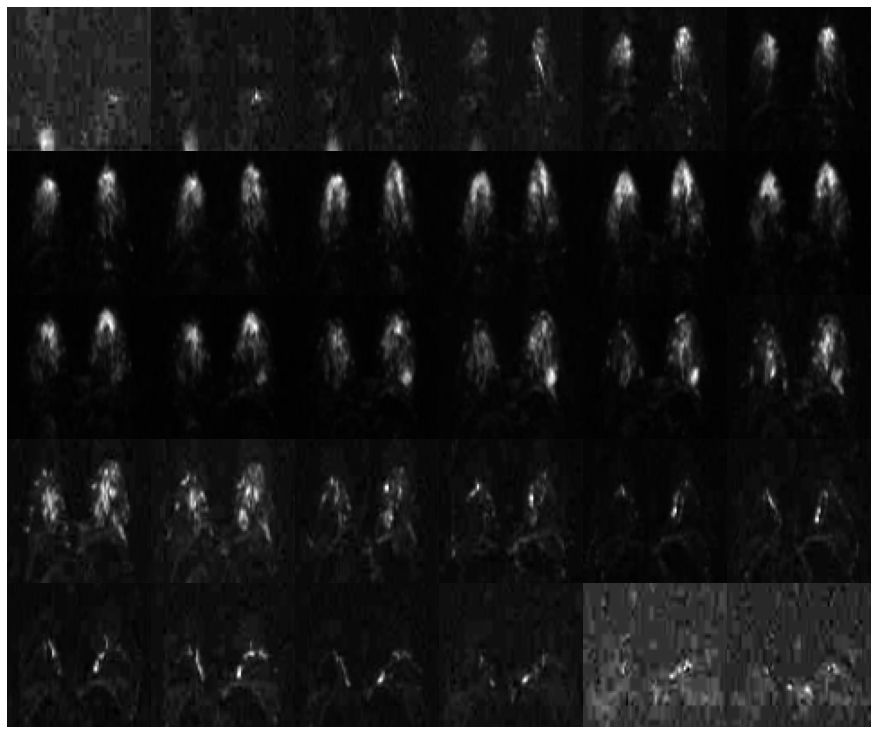

In [9]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = pyplot.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    pyplot.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    pyplot.show()

image = image_nparrays[0]
print("Dimension of 3D image is:", image.shape)

# Visualize montage of slices.
plot_slices(5, 6, 80, 80, image[:, :, :30])

### Step 5. Loading prediction model
>#### Description: 사전에 훈련된 예측모델(모델의 파일이름 변수:model_filename)을 로딩하고 모델의 성능을 평가합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [11]:
#load prediction model
model_filename = 'model.unimodal.MRI_TNBC_imtype.hdf5'
from keras.models import load_model
model = load_model(model_filename)

### Step 6. Perform the predictor
>#### Description: 사용자가 입력한 데이터로 TNBC 환자의 면역형(IM or non-IM)를 예측합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [13]:
#Predicting of risk group of individual
prd_list = np.argmax(model.predict(image_nparrays), axis=1)

for idx in range(len(prd_list)):
    if (prd_list[idx] == 0):
        print("Risk group of", patient_list[idx], ": non-IM")
    elif (prd_list[idx] == 1):
        print("Risk group of", patient_list[idx], ": IM")

Risk group of TNBC_003 : non-IM
Risk group of TNBC_004 : non-IM
Risk group of TNBC_005 : non-IM
Risk group of TNBC_006 : non-IM
Risk group of TNBC_008 : non-IM
Risk group of TNBC_009 : non-IM
Risk group of TNBC_010 : non-IM
Risk group of TNBC_011 : non-IM
Risk group of TNBC_012 : non-IM
Risk group of TNBC_013 : non-IM
Risk group of TNBC_014 : non-IM
Risk group of TNBC_015 : non-IM
Risk group of TNBC_016 : non-IM
Risk group of TNBC_017 : non-IM
Risk group of TNBC_019 : non-IM
Risk group of TNBC_020 : IM
Risk group of TNBC_021 : IM
Risk group of TNBC_022 : non-IM
Risk group of TNBC_023 : non-IM
Risk group of TNBC_024 : non-IM
Risk group of TNBC_026 : non-IM
Risk group of TNBC_027 : non-IM
Risk group of TNBC_028 : non-IM
Risk group of TNBC_029 : non-IM
Risk group of TNBC_031 : non-IM
Risk group of TNBC_032 : non-IM
Risk group of TNBC_033 : non-IM
Risk group of TNBC_034 : non-IM
Risk group of TNBC_035 : non-IM
Risk group of TNBC_036 : non-IM
Risk group of TNBC_037 : non-IM
Risk group of TN